# Create a model using DistilBERT tuned on route and gear data

In [22]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig, TFAutoModelWithLMHead, TFAutoModel, AutoModel

from sklearn.model_selection import train_test_split

import tensorflow as tf

import pandas as pd
import numpy as np

classifier = pipeline('sentiment-analysis')

In [23]:
import random
random.seed(42)

In [24]:
save_directory = "models/trailspace_and_route_model"

In [25]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFAutoModel.from_pretrained(save_directory, from_pt=False, config = config)

input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(3, activation='sigmoid')(X)
tf.keras.layers.Softmax(axis=-1)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False
    
model.compile(optimizer="Adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["acc"])

All model checkpoint weights were used when initializing TFDistilBertModel.

All the weights of TFDistilBertModel were initialized from the model checkpoint at models/trailspace_and_route_model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [26]:
df = pd.read_csv('data/labeled_forum_test.csv')
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], test_size=0.20, random_state=42)

In [27]:
# Create X values
tokenizer = AutoTokenizer.from_pretrained(save_directory)
X_train = tokenizer(
     list(X_train),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 128
 )

X_test = tokenizer(
     list(X_test),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 128
 )

In [28]:
# Create Y values
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [29]:
history = model.fit([X_train["input_ids"], X_train["attention_mask"]], 
          y_train, 
          batch_size=128, 
          epochs=30, 
          verbose=1, 
          validation_split=0.2)

Train on 2591 samples, validate on 648 samples
Epoch 1/30
2591/2591 [==============================] - 150s 58ms/sample - loss: 0.7342 - acc: 0.7449 - val_loss: 0.6786 - val_acc: 0.7500
Epoch 2/30
2591/2591 [==============================] - 152s 59ms/sample - loss: 0.6434 - acc: 0.7526 - val_loss: 0.6188 - val_acc: 0.7500
Epoch 3/30
2591/2591 [==============================] - 142s 55ms/sample - loss: 0.5973 - acc: 0.7596 - val_loss: 0.5790 - val_acc: 0.7793
Epoch 4/30
2591/2591 [==============================] - 143s 55ms/sample - loss: 0.5618 - acc: 0.7731 - val_loss: 0.5545 - val_acc: 0.7778
Epoch 5/30
2591/2591 [==============================] - 141s 55ms/sample - loss: 0.5422 - acc: 0.7816 - val_loss: 0.5581 - val_acc: 0.7809
Epoch 6/30
2591/2591 [==============================] - 141s 54ms/sample - loss: 0.5228 - acc: 0.7781 - val_loss: 0.5285 - val_acc: 0.7994
Epoch 7/30
2591/2591 [==============================] - 142s 55ms/sample - loss: 0.4862 - acc: 0.8043 - val_loss: 0.521

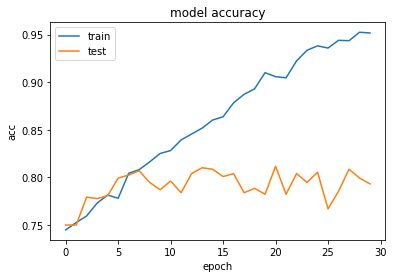

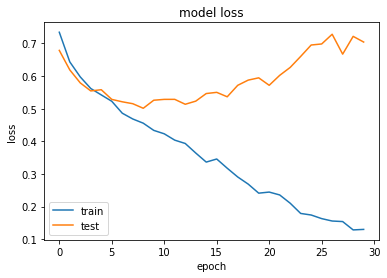

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='lower left')
plt.show()

In [32]:
score = model.evaluate([X_test["input_ids"], X_test["attention_mask"]], y_test, verbose=1)

810/810 [==============================] - 54s 67ms/sample - loss: 0.6503 - acc: 0.8185


In [33]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6503186013963488
Test Accuracy: 0.8185185


In [34]:
model.save_weights('models/final_models/route_and_gear/route_and_gear')

## best epoch is 8:
loss: 0.4685 - acc: 0.8082 - val_loss: 0.5153 - val_acc: 0.8071

In [36]:
history = model.fit([X_train["input_ids"], X_train["attention_mask"]], 
          y_train, 
          batch_size=128, 
          epochs=8, 
          verbose=1, 
          validation_split=0.2)

Train on 2591 samples, validate on 648 samples
Epoch 1/8
2591/2591 [==============================] - 239s 92ms/sample - loss: 0.1070 - acc: 0.9645 - val_loss: 0.7557 - val_acc: 0.7932
Epoch 2/8
2591/2591 [==============================] - 236s 91ms/sample - loss: 0.1017 - acc: 0.9645 - val_loss: 0.7718 - val_acc: 0.7948
Epoch 3/8
2591/2591 [==============================] - 245s 95ms/sample - loss: 0.0954 - acc: 0.9653 - val_loss: 0.7886 - val_acc: 0.7840
Epoch 4/8
2591/2591 [==============================] - 246s 95ms/sample - loss: 0.0969 - acc: 0.9672 - val_loss: 0.7561 - val_acc: 0.7886
Epoch 5/8
2591/2591 [==============================] - 239s 92ms/sample - loss: 0.1023 - acc: 0.9599 - val_loss: 0.7701 - val_acc: 0.7855
Epoch 6/8
2591/2591 [==============================] - 240s 93ms/sample - loss: 0.1028 - acc: 0.9637 - val_loss: 0.7853 - val_acc: 0.7963
Epoch 7/8
2591/2591 [==============================] - 164s 63ms/sample - loss: 0.0801 - acc: 0.9734 - val_loss: 0.8610 - val

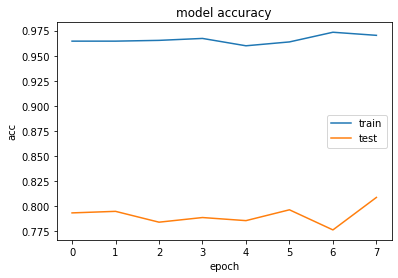

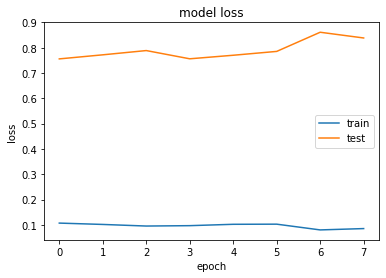

In [40]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='center right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='center right')
plt.show()

In [38]:
score = model.evaluate([X_test["input_ids"], X_test["attention_mask"]], y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

810/810 [==============================] - 31s 38ms/sample - loss: 0.7965 - acc: 0.8148
Test Score: 0.7964552502573272
Test Accuracy: 0.8148148


In [39]:
model.save_weights('models/final_models/route_and_gear2/route_and_gear2')